In [43]:
import numpy as numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import shap 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [100]:
# read in clean data
df = pd.read_csv("../../data/clean_data.csv")

In [101]:
# simple eda
df.head()

,Decision,State,GPA,WorkExp,TestScore,WritingScore,Gender,VolunteerLevel
0,Admit,California,3.90,6.7,962.0,100,1.0,0
1,Admit,Florida,3.80,1.4,969.0,97,1.0,4
2,Admit,Colorado,3.60,0.9,969.0,97,0.0,2
3,Admit,California,3.88,1.5,967.0,95,1.0,5
4,Admit,California,3.70,1.2,969.0,94,1.0,2


In [102]:
df.dtypes

Decision           object
State              object
GPA               float64
WorkExp           float64
TestScore         float64
WritingScore        int64
Gender            float64
VolunteerLevel      int64
dtype: object

In [103]:
# one hot encoding state 
# df_encoded = pd.DataFrame(df)
# df_encoded = pd.get_dummies(df, columns=['State'])

#df_encoded.head()

In [104]:
# encode target variable
label_encoder = LabelEncoder()
df_encoded = pd.DataFrame(df)
df_encoded['State'] = label_encoder.fit_transform(df_encoded['State'])
print(label_encoder.classes_)

df_encoded['Decision'] = label_encoder.fit_transform(df_encoded['Decision'])
print(label_encoder.classes_)
# ['Admit' 'Decline' 'Waitlist']
#    0         1         2


# Display the first few rows to confirm encoding
df_encoded.head()




['Alabama' 'California' 'Colorado' 'Florida' 'Mississippi' 'New York'
 'Oregon' 'Utah' 'Vermont' 'Virginia']
['Admit' 'Decline' 'Waitlist']


,Decision,State,GPA,WorkExp,TestScore,WritingScore,Gender,VolunteerLevel
0,0,1,3.90,6.7,962.0,100,1.0,0
1,0,3,3.80,1.4,969.0,97,1.0,4
2,0,2,3.60,0.9,969.0,97,0.0,2
3,0,1,3.88,1.5,967.0,95,1.0,5
4,0,1,3.70,1.2,969.0,94,1.0,2


In [105]:
# split up data 
X = df_encoded.drop('Decision', axis=1)
y = df_encoded['Decision']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# initialize classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.5,
                    n_estimators=150,
                    max_depth=6,
                    min_child_weight=0,
                    gamma=0,
                    reg_lambda=1,
                    subsample=1,
                    colsample_bytree=0.75,
                    scale_pos_weight=1,
                    objective='multi:softprob',
                    num_class=3,
                    random_state=42)

# train
model = xgb_clf.fit(X_train, y_train)

# test
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)


[10:04:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1705650162823/work/src/learner.cc:742: 
Parameters: { "scale_pos_weight" } are not used.



In [118]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report (Precision, Recall, F1-Score)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      0.67      0.80         6
           2       0.60      1.00      0.75         3

    accuracy                           0.88        16
   macro avg       0.87      0.89      0.85        16
weighted avg       0.93      0.88      0.88        16

Confusion Matrix:
 [[7 0 0]
 [0 4 2]
 [0 0 3]]


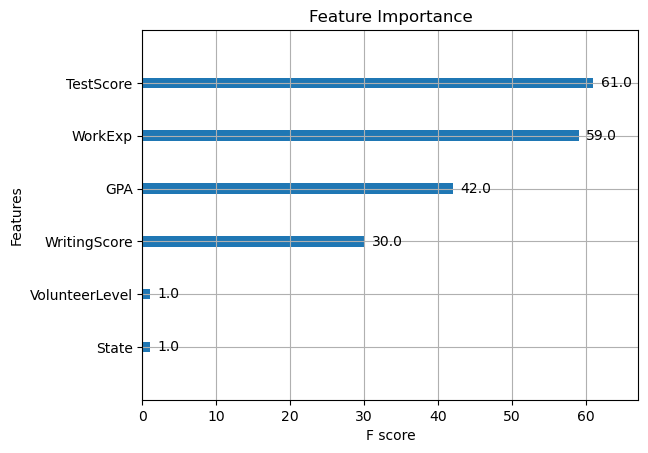

In [108]:
# visualize xgb feat importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

[0 1 2]


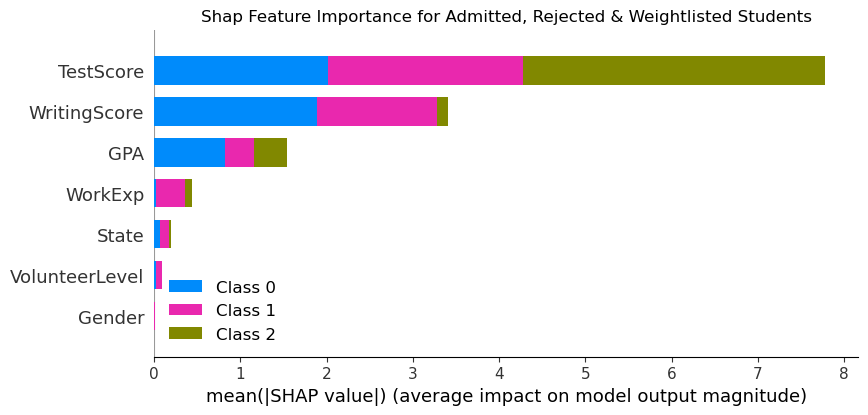

In [164]:
# Calculate SHAP values - this might take some time for larger models/datasets
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Summarize the effects of all the features
print(model.classes_)

fig = plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show = False)
plt.gcf().set_size_inches(9,4)
plt.title("Shap Feature Importance for Admitted, Rejected & Weightlisted Students")
plt.show()

# ['Admit' 'Decline' 'Waitlist']
#    0         1         2

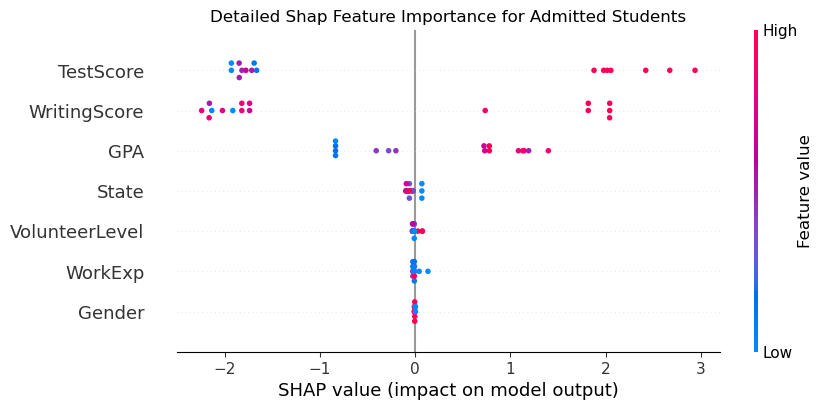

In [152]:
# Detailed summary plot for the first class
class_index = 0
shap.summary_plot(shap_values[class_index], X_test, plot_type="dot", show=False)
plt.gcf().set_size_inches(9,4)
plt.title("Detailed Shap Feature Importance for Admitted Students")
plt.show()


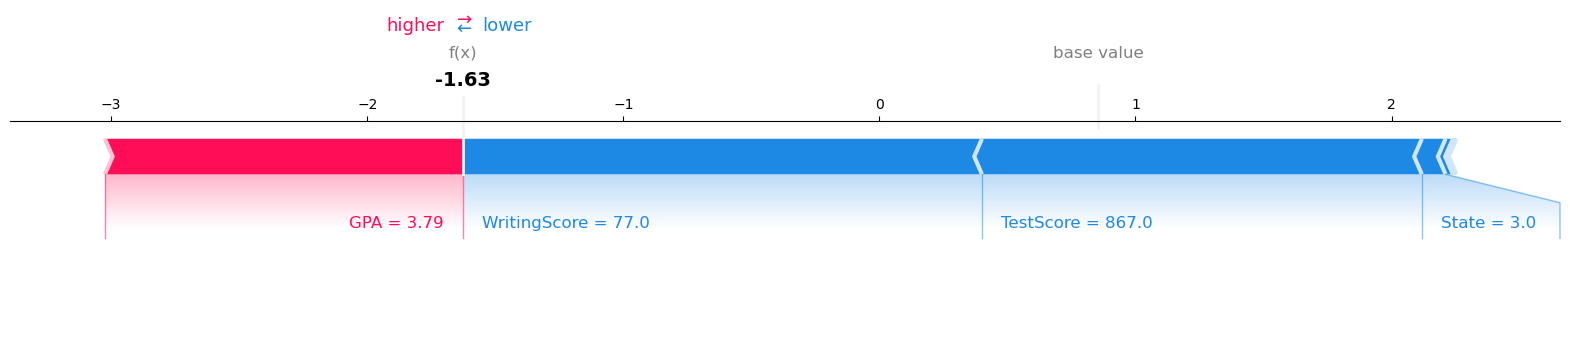

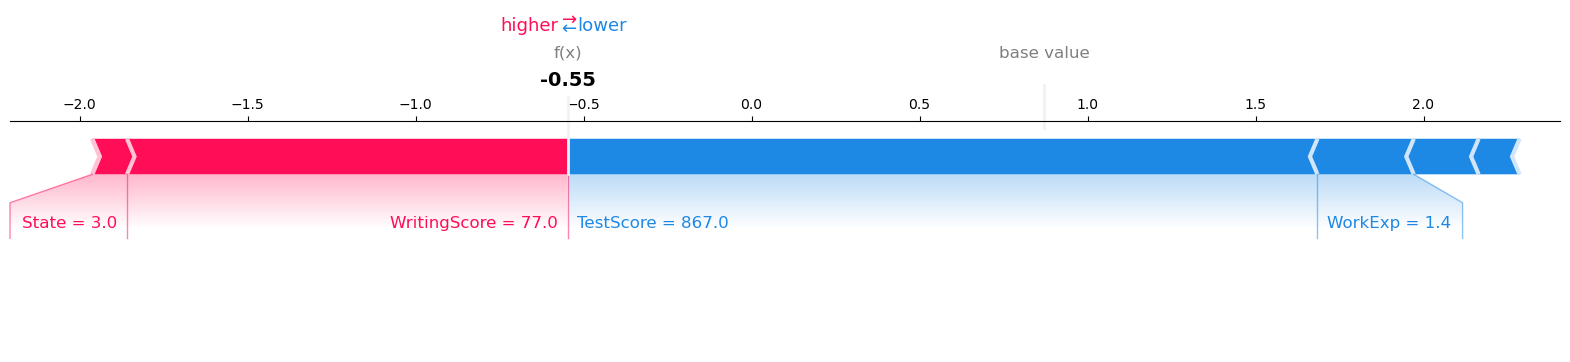

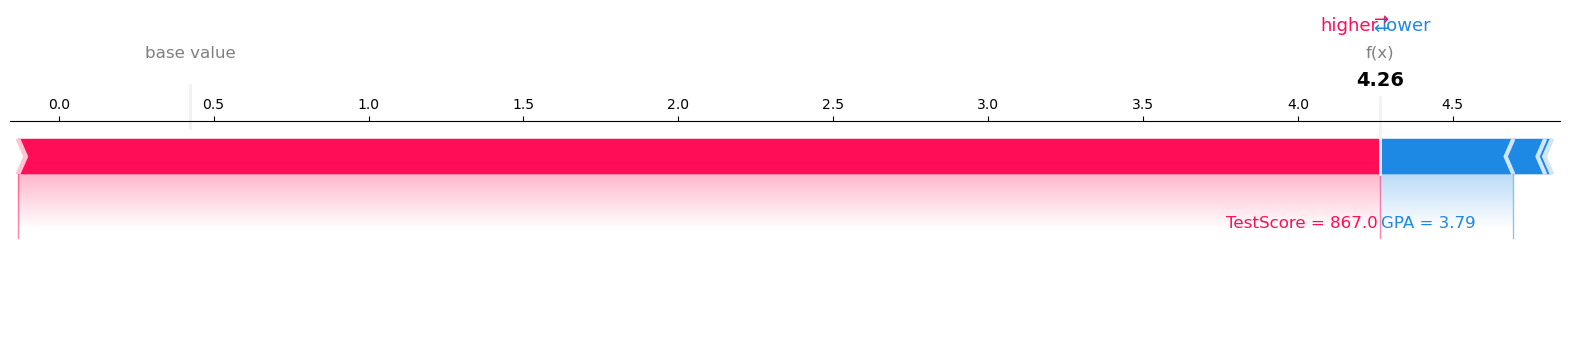

In [150]:
for class_idx in range(0,3):
    shap.force_plot(explainer.expected_value[class_idx], shap_values[class_idx][0,:], X_test.iloc[0,:], matplotlib=True)


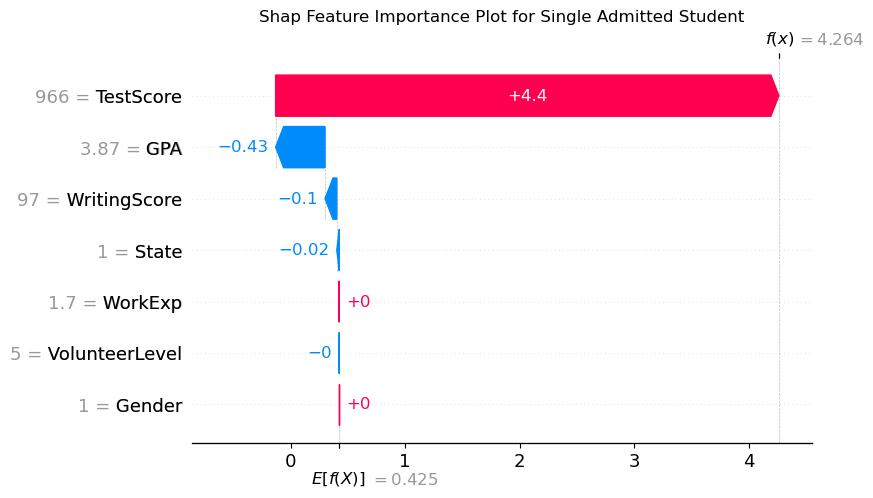

In [163]:
expl = shap.Explanation(values=shap_values[2][0],
                        base_values=explainer.expected_value[2],
                        data=X_test.iloc[5,:],
                        feature_names=X_test.columns.tolist())

# Now, you can use this Explanation object with the waterfall plot
shap.plots.waterfall(expl, show=False)
plt.title("Shap Feature Importance Plot for Single Admitted Student")
plt.show()

#https://towardsdatascience.com/explainable-ai-xai-with-shap-multi-class-classification-problem-64dd30f97cea

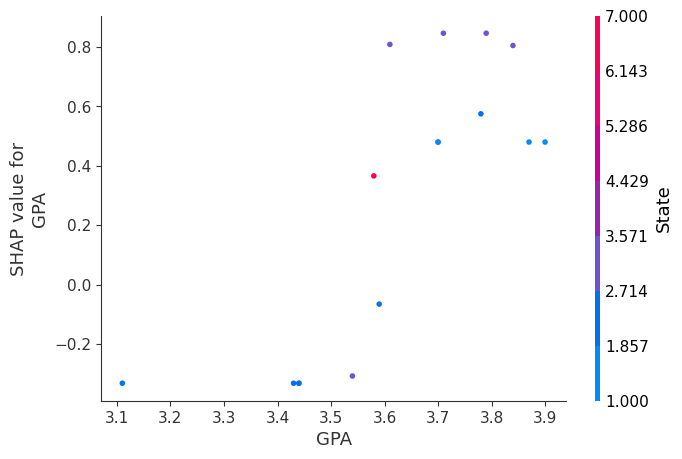

<Figure size 700x500 with 0 Axes>

In [115]:
feature_name = "GPA"  # Change this to your actual feature name
shap.dependence_plot(feature_name, shap_values[class_index], X_test)
plt.gcf().set_size_inches(7, 5)  # Adjust size as needed
plt.show()